In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
cd 'drive/My Drive/Development/Biometrics/evaluation'

/content/drive/My Drive/Development/Biometrics/evaluation
[Errno 2] No such file or directory: 'drive/My Drive/Development/Biometrics/evaluation'
/content/drive/My Drive/Development/Biometrics/evaluation


In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xml.etree.ElementTree as ET # work with XML
import os
import pandas as pd # data analysis
from tqdm.notebook import tqdm as tqdm_notebook # progress bar
import BSSR1
import seaborn as sns
sns.set(style="darkgrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Read Dataset


In [0]:
# Links to relevant files
li_enrollees_id_filepath = './fing_x_fing/sets/dos/li/enrollees.xml'
li_users_id_filepath = './fing_x_fing/sets/dos/li/users.xml'
li_scores_list_str = './fing_x_fing/sims/dos/li/V/*.bin'
ri_enrollees_id_filepath = './fing_x_fing/sets/dos/ri/enrollees.xml'
ri_users_id_filepath = './fing_x_fing/sets/dos/ri/users.xml'
ri_scores_list_str = './fing_x_fing/sims/dos/ri/V/*.bin'

In [0]:
# Flag to toggle complete fingerprint database loading on / off.
#   Only set this to true if there's no pickle file.
LOAD_ALL = False

# Read BSSR1 scores (this might take a while)
if LOAD_ALL:
  (li_fingxfing_dataframe, li_enrollees, li_users, li_column_names) = \
    BSSR1.read_BSSR1_scores_from_file(li_enrollees_id_filepath, 
                                      li_users_id_filepath, 
                                      li_scores_list_str)
  (ri_fingxfing_dataframe, ri_enrollees, ri_users, ri_column_names) = \
    BSSR1.read_BSSR1_scores_from_file(ri_enrollees_id_filepath, 
                                      ri_users_id_filepath, 
                                      ri_scores_list_str)

In [0]:
# Subsample the scores to a manageable number of individuals
import pickle # Save and read intermediate results

if LOAD_ALL:
  li_file = open( "saved_li_matrix.p", "wb")
  ri_file = open( "saved_ri_matrix.p", "wb")
  li_similarity_matrix = \
    BSSR1.df2sim_subsample(li_fingxfing_dataframe, 
                          column_names = li_column_names, 
                          nr_individuals = 1000)
  ri_similarity_matrix = \
    BSSR1.df2sim_subsample(ri_fingxfing_dataframe, 
                          column_names = ri_column_names, 
                          nr_individuals = 1000)
  # Save subsamples to speed up colab loading
  #   (colaboratory is quite slow with the google drive)
  pickle.dump(li_similarity_matrix, li_file)
  pickle.dump(ri_similarity_matrix, ri_file)
else:
  # Simply load subsamples saved before
  li_file = open( "saved_li_matrix.p", "rb")
  ri_file = open( "saved_ri_matrix.p", "rb")
  li_similarity_matrix = pickle.load(li_file)
  ri_similarity_matrix = pickle.load(ri_file)

In [0]:
# Convert to genuine and imposter scores, 
#   the *_genuine_id provides a mask for the genuine scores
li_genuine_id, li_scores = BSSR1.sim2scores(li_similarity_matrix)
ri_genuine_id, ri_scores = BSSR1.sim2scores(ri_similarity_matrix)

## Validation of verification system

### Evaluation using FMR, FRR, ROC and Precision/Recall curves


#### Task 1.1 Plot and describe the score distributions

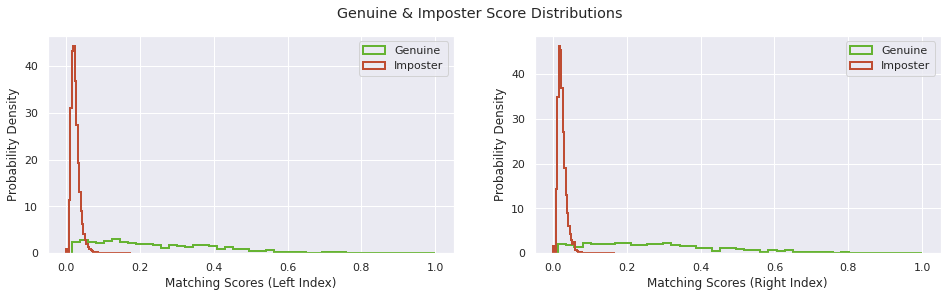

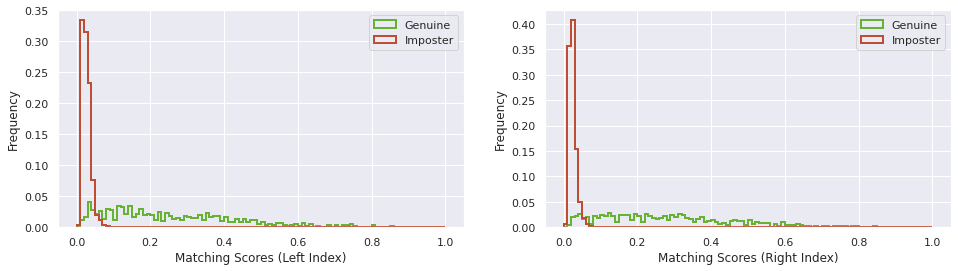

In [69]:
"""Plot the genuine and imposter score distributions."""

# The picture of distributions given above and in Jain says 'probability' 
#   on the y-axis, but this is not a probability. Hereunder, 
#   both a pdf and frequencies are plotted. The pdf is easier to 
#   interpret.
def to_weights(array):
    return np.ones_like(array) / float(len(array))
li_genuine_weights = to_weights(li_scores[li_genuine_id > 0])
li_imposter_weights = to_weights(li_scores[li_genuine_id < 1])
ri_genuine_weights = to_weights(ri_scores[ri_genuine_id > 0])
ri_imposter_weights = to_weights(ri_scores[ri_genuine_id < 1])

# Probability density functions
kwargs = dict(histtype='step', density=True, bins=45, lw=2)
figure, axes = plt.subplots(ncols=2, figsize=(16,4))
figure.suptitle('Genuine & Imposter Score Distributions')
axes[0].hist(li_scores[li_genuine_id > 0], 
             color=(0.4,0.7,0.2), 
             label='Genuine',
             **kwargs)
axes[0].hist(li_scores[li_genuine_id < 1], 
             color=(0.75,0.3,0.2), 
             label='Imposter', 
             **kwargs)
axes[0].set(xlabel='Matching Scores (Left Index)', 
            ylabel='Probability Density')
axes[0].legend();
axes[1].hist(ri_scores[ri_genuine_id > 0], 
             color=(0.4,0.7,0.2), 
             label='Genuine', 
             **kwargs)
axes[1].hist(ri_scores[ri_genuine_id < 1], 
             color=(0.75,0.3,0.2), 
             label='Imposter', 
             **kwargs)
axes[1].legend();
axes[1].set(xlabel='Matching Scores (Right Index)', 
            ylabel='Probability Density')
plt.show()

# Plot frequencies
kwargs = dict(histtype='step', 
              density=False,
              lw=2,
              bins=np.arange(0.0, 1.01, 0.01)) # bins=45 (fixed # of bins)
figure, axes = plt.subplots(ncols=2, figsize=(16,4))
axes[0].hist(li_scores[li_genuine_id > 0], 
             weights=li_genuine_weights, 
             color=(0.4,0.7,0.2), 
             label='Genuine', 
             **kwargs)
axes[0].hist(li_scores[li_genuine_id < 1], 
             weights=li_imposter_weights, 
             color=(0.75,0.3,0.2), 
             label='Imposter', 
             **kwargs)
axes[0].set(xlabel='Matching Scores (Left Index)', 
            ylabel='Frequency')
axes[0].legend();
axes[1].hist(ri_scores[ri_genuine_id > 0], 
             weights=ri_genuine_weights, 
             color=(0.4,0.7,0.2), 
             label='Genuine', 
             **kwargs)
axes[1].hist(ri_scores[ri_genuine_id < 1], 
             weights=ri_imposter_weights, 
             color=(0.75,0.3,0.2), 
             label='Imposter', 
             **kwargs)
axes[1].legend();
axes[1].set(xlabel='Matching Scores (Right Index)', ylabel='Frequency')
plt.show()

*The distributions do need to be normalised as there are many more imposter scores than genuine scores (1000 vs. 999000). Imposter scores tend to be small whereas genuine scores are quite varied yet unlikely to be smaller than any of the imposter scores. This allows one to create a system that can perform adequately by deciding for a threshold that satisfies the desired requirements, as discussed in the next sections.*

#### 2. FMR, FRR and Receiver Operating Characteristic (ROC) curve

#### Task 1.2 Plot and discuss ROC curve 

* Calculate FPR, TPR from the matching scores.
* Plot FAR and FRR as a function of matching scores.
* Plot the ROC curve. Plot for linear and logarithmic scale if needed. What do you observe? 
* Plot the Detection Error Trade-off (DET) curve. How does it compare to ROC?

Use the [scikit-learn](https://scikit-learn.org/stable/index.html) package.

In [0]:
from sklearn.metrics import roc_curve

In [0]:
"""Calculate FPR, TPR from the matching scores."""
#default = 0.6
#def fpr(imposter_scores=li_scores[li_genuine_id < 1], threshold=default):
#    return len(imposter_scores[imposter_scores >= threshold]) / float(len(imposter_scores))
#def tpr(genuine_scores=li_scores[li_genuine_id > 0], threshold=default):
#    return len(genuine_scores[genuine_scores >= threshold]) / float(len(genuine_scores))
#print("FPR (threshold = % .1f) : % f" % (default, fpr()))
#print("TPR (threshold = % .1f) : % f" % (default, tpr()))
li_fpr, li_tpr, li_roc_thresholds = roc_curve(li_genuine_id, li_scores)
ri_fpr, ri_tpr, ri_roc_thresholds = roc_curve(ri_genuine_id, ri_scores)

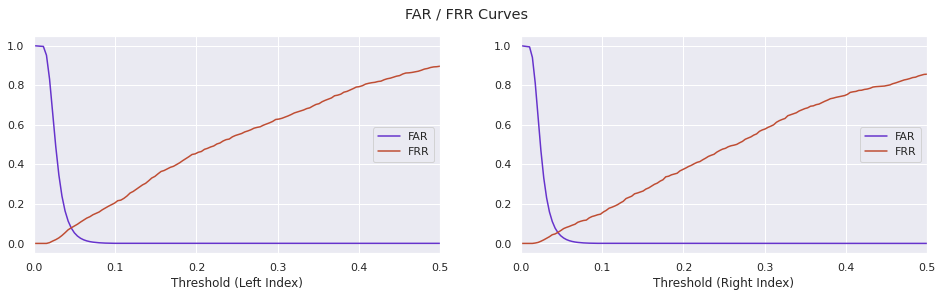

In [108]:
"""Plot FAR and FRR as a function of matching scores."""
#thresholds = np.linspace(0.0,1.0,100).tolist()
#li_far = [fpr(threshold=t) for t in thresholds]
#li_frr = [1 - tpr(threshold=t) for t in thresholds]
#ri_imposter_scores = li_scores[li_genuine_id < 1]
#ri_genuine_scores = li_scores[li_genuine_id > 0]
#ri_far = [fpr(ri_imposter_scores, t) for t in thresholds]
#ri_frr = [1 - tpr(ri_genuine_scores, t) for t in thresholds]
figure, axes = plt.subplots(ncols=2, figsize=(16,4))
figure.suptitle('FAR / FRR Curves')
axes[0].plot(li_roc_thresholds, li_fpr, color=(0.4,0.2,0.8), label='FAR')
axes[0].plot(li_roc_thresholds, 1-li_tpr, color=(0.75,0.3,0.2), label='FRR')
axes[0].set(xlabel='Threshold (Left Index)', xlim=[0.0,0.5])
axes[0].legend();
axes[1].plot(ri_roc_thresholds, ri_fpr, color=(0.4,0.2,0.8), label='FAR')
axes[1].plot(ri_roc_thresholds, 1-ri_tpr, color=(0.75,0.3,0.2), label='FRR')
axes[1].set(xlabel='Threshold (Right Index)', xlim=[0.0,0.5])
axes[1].legend();

*As the threshold rises, the probability of false matches steadily decreases, whereas the probability of false rejections increases more slowly as the genuine scores are more spread out.*

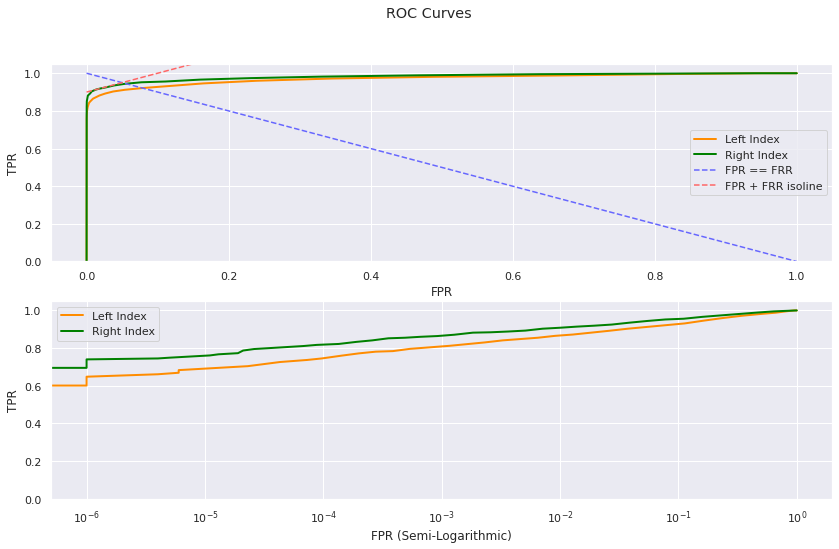

In [109]:
"""Plot the ROC curve (TPR against the FPR for different threshold values)"""
figure, axes = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
figure.suptitle('ROC Curves')
axes[0].plot(li_fpr, li_tpr, color='darkorange', lw=2, label='Left Index')
axes[0].plot(ri_fpr, ri_tpr, color='green', lw=2, label='Right Index')
equal = np.linspace(0.0,1.0,50).tolist() # FPR == FRR
axes[0].plot(equal, equal[::-1], '--', color=[0.4,0.4,1.0], label='FPR == FRR')
axes[0].plot([0.0,0.2], [0.9,1.1], '--', color=[1.0,0.4,0.4], label='FPR + FRR isoline')
axes[0].set(xlabel='FPR', ylabel='TPR', ylim=[0.0,1.05])
axes[0].legend();
axes[1].semilogx(li_fpr, li_tpr, color='darkorange', lw=2, label='Left Index')
axes[1].semilogx(ri_fpr, ri_tpr, color='green', lw=2, label='Right Index')
axes[1].set(xlabel='FPR (Semi-Logarithmic)', ylabel='TPR', ylim=[0.0,1.05])
axes[1].legend();
plt.show()

*When there's a large class imbalance an ROC curve can still look good even when the system misclassifies a lot (in this case the curve is very steep when the FPR is low).  However, even in that case two systems could still be compared on the same dataset as is done here. If one curve is consistently higher than the other the system simply outperforms the other, while if there had been an intersection each system would be better than the other in a particular context (certain thresholds).*

*If one were to choose an operating point on the basis of the curve it's useful to note that FPR deals with security and TPR with convenience, with most systems prioritising the former.*

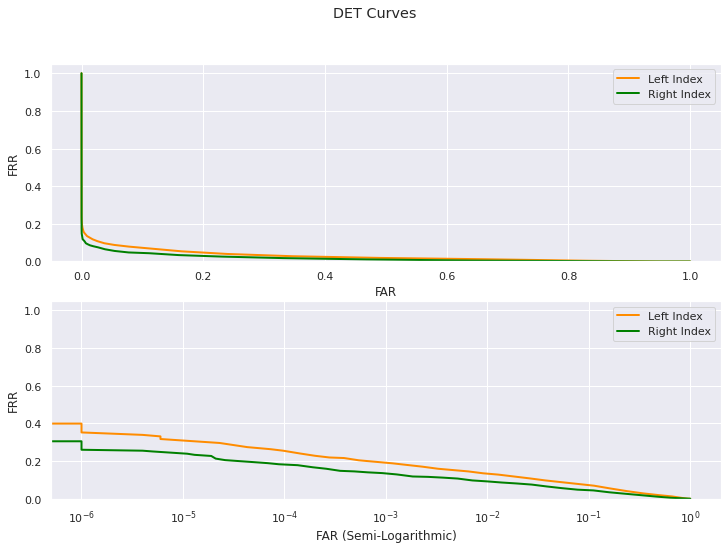

In [110]:
"""Plot the DET curve (FRR (=1-tpr) against the FAR for different threshold values)"""
figure, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
figure.suptitle('DET Curves')
axes[0].plot(li_fpr, 1-li_tpr, color='darkorange', lw=2, label='Left Index')
axes[0].plot(ri_fpr, 1-ri_tpr, color='green', lw=2, label='Right Index')
axes[0].set(xlabel='FAR', ylabel='FRR', ylim=[0.0,1.05])
axes[0].legend();
axes[1].semilogx(li_fpr, 1-li_tpr, color='darkorange', lw=2, label='Left Index')
axes[1].semilogx(ri_fpr, 1-ri_tpr, color='green', lw=2, label='Right Index')
axes[1].set(xlabel='FAR (Semi-Logarithmic)', ylabel='FRR', ylim=[0.0,1.05])
axes[1].legend();
plt.show()

*The DET curve doesn't tell anything new, the y-axis is inverted. Sometimes a normal deviate scale is used to make the results visually pleasing.*

#### 3. F1 and accuracy as metrics

#### Task 1.3 Calculate and discuss F1 and accuracy

* Plot F1 and accuracy as a function of the decision thresholds on the similarity score.
 * Interpret these two curves.
* Calculate the threshold for which F1 is maximal. 
 * Is it an interesting operating point?
 * What is the accuracy for this operating point? 
* Do the same for the classification error (or accuracy).
 * is there any difference between the two settings? Why(not)?
* Is accuracy a good performance measure for this case? Why(not)?

Use the scikit-learn [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) to assist.

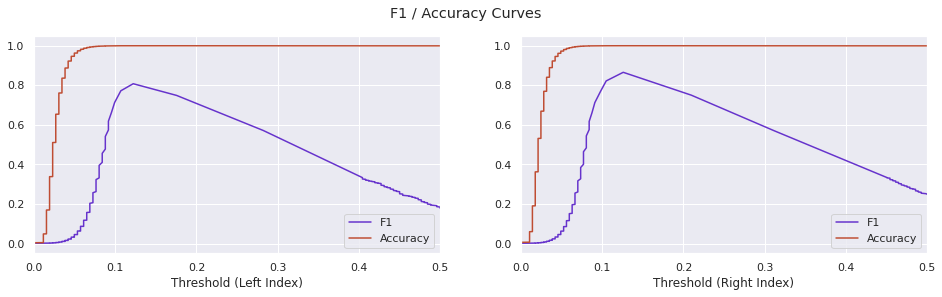

In [111]:
"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
def get_metrics(genuine_id, scores):
  genuine = genuine_id.tolist()
  true_positives = genuine.count(1)
  true_negatives = 0
  false_positives = genuine.count(0)
  false_negatives = 0
  is_genuine = 0
  f1_scores = []
  accuracies = []
  update = 0
  for (threshold,index) in sorted((s,i) for i,s in enumerate(scores)):
    if update:
      true_positives = true_positives - is_genuine
      true_negatives = true_negatives + (1-is_genuine)
      false_positives = false_positives - (1-is_genuine)
      false_negatives = false_negatives + is_genuine
    else:
      update = 1
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_scores.append(2 * precision * recall / (precision + recall))
    accuracies.append((true_positives + true_negatives) / len(scores))
    is_genuine = (genuine[index] == 1)
  return (np.asarray(sorted(scores)), np.asarray(f1_scores), np.asarray(accuracies))

(li_thresholds, li_f1_scores, li_accuracy_scores) = get_metrics(li_genuine_id, li_scores)
(ri_thresholds, ri_f1_scores, ri_accuracy_scores) = get_metrics(ri_genuine_id, ri_scores)
subset = [i for i in range(0, len(li_scores), 200)] + [i for i in range(len(li_scores)-200, len(li_scores), 1)]
#from sklearn.metrics import f1_score, accuracy_score
#li_f1_scores = [f1_score(li_genuine_id, np.where(li_scores >= t, 1, 0)) for t in thresholds]
#li_accuracy_scores = [accuracy_score(li_genuine_id, np.where(li_scores >= t, 1, 0)) for t in thresholds]
#thresholds = np.linspace(0.0,1.0,100).tolist() # hint: evaluating for ± 50 threshold values should suffice
#ri_f1_scores = [f1_score(ri_genuine_id, np.where(ri_scores >= t, 1, 0)) for t in thresholds]
#ri_accuracy_scores = [accuracy_score(ri_genuine_id, np.where(ri_scores >= t, 1, 0)) for t in thresholds]
figure, axes = plt.subplots(ncols=2, figsize=(16,4))
figure.suptitle('F1 / Accuracy Curves')
axes[0].plot(li_thresholds[subset], li_f1_scores[subset], color=(0.4,0.2,0.8), label='F1')
axes[0].plot(li_thresholds[subset], li_accuracy_scores[subset], color=(0.75,0.3,0.2), label='Accuracy')
axes[0].set(xlabel='Threshold (Left Index)', xlim=[0.0,0.5])
axes[0].legend();
axes[1].plot(ri_thresholds[subset], ri_f1_scores[subset], color=(0.4,0.2,0.8), label='F1')
axes[1].plot(ri_thresholds[subset], ri_accuracy_scores[subset], color=(0.75,0.3,0.2), label='Accuracy')
axes[1].set(xlabel='Threshold (Right Index)', xlim=[0.0,0.5])
axes[1].legend();
plt.show()

*The accuracy increases until a threshold where the bulk of the imposters are effectively considered imposters. Then it drops as it keeps mislabeling more and more genuine scores. Since there are many more imposter than genuine scores the accuracy barely seems to change, however, whereas the F1 score visibly decreases. The accuracy takes into account true negatives and since there's so many of those it gives an optimistic picture.*

In [112]:
"""Calculate the threshold for which F1 is maximal."""
li_max_f1_t = li_thresholds[li_f1_scores.tolist().index(max(li_f1_scores))]
ri_max_f1_t = ri_thresholds[ri_f1_scores.tolist().index(max(ri_f1_scores))]
print("Max F1 score at threshold = %f (Left Index)." % li_max_f1_t)
print("Accuracy at this threshold = %f." % accuracy_score(li_genuine_id, np.where(li_scores >= li_max_f1_t, 1, 0)))
print("Maximum imposter score %f" % max(li_scores[li_genuine_id < 1]))
li_imposter = li_scores[li_genuine_id < 1]
li_genuine = li_scores[li_genuine_id > 0]
print("FPR at this threshold = %f." % (len(li_imposter[li_imposter >= li_max_f1_t]) / float(len(li_imposter))))
print("FRR at this threshold = %f." % (len(li_genuine[li_genuine < li_max_f1_t]) / float(len(li_genuine))))
print("---")
print("Max F1 score at threshold = %f (Right Index)." % ri_max_f1_t)
print("Accuracy at this threshold = %f." % accuracy_score(ri_genuine_id, np.where(ri_scores >= ri_max_f1_t, 1, 0)))
print("Maximum imposter score %f" % max(ri_scores[ri_genuine_id < 1]))
ri_imposter = ri_scores[ri_genuine_id < 1]
ri_genuine = ri_scores[ri_genuine_id > 0]
print("FPR at this threshold = %f." % (len(ri_imposter[ri_imposter >= ri_max_f1_t]) / float(len(ri_imposter))))
print("FRR at this threshold = %f." % (len(ri_genuine[ri_genuine < ri_max_f1_t]) / float(len(ri_genuine))))

Max F1 score at threshold = 0.125954 (Left Index).
Accuracy at this threshold = 0.999683.
Maximum imposter score 0.175573
FPR at this threshold = 0.000043.
FRR at this threshold = 0.274000.
---
Max F1 score at threshold = 0.122378 (Right Index).
Accuracy at this threshold = 0.999769.
Maximum imposter score 0.167832
FPR at this threshold = 0.000026.
FRR at this threshold = 0.205000.


*It is a somewhat useful operating point, with some caveats. The F1 score doesn't take into account true negatives, and an other balance between precision/recall may be desired instead of the harmonic mean. In this specific case the FPR turns out to be quite low (as precision is maximised) but the FRR is high, somewhere between 20-30%. The reason is that false positives and false negatives are considered to have the same cost but there's many more imposters so the FPR is minimised more than the FRR.*

In [113]:
"""Do the same for the classification error (or accuracy)"""
#print(sum(np.where(li_scores[li_genuine_id < 1] >= 0.13, 1, 0)))
#print(sum(np.where(ri_scores[ri_genuine_id < 1] >= 0.13, 1, 0)))
print("Max Accuracy score at threshold %f (Left Index)." % li_thresholds[li_accuracy_scores.tolist().index(max(li_accuracy_scores))])
print("Max Accuracy score at threshold %f (Right Index)." % li_thresholds[ri_accuracy_scores.tolist().index(max(ri_accuracy_scores))])

Max Accuracy score at threshold 0.125954 (Left Index).
Max Accuracy score at threshold 0.118321 (Right Index).


*Clearly, accuracy doesn't deal well with the class imbalance that happens to be common in biometrics. A threshold of 0.9 would render the system rather useless yet its accuracy remains high.*

*It is normal that accuracy and F1 are both maximal for the same threshold even though F1 doesn't take the true negatives into account. When the threshold is larger than most of the imposter scores the precision still increases and so does the accuracy. True negatives don't play much of a role anymore in this region.*

In [0]:
# To be ignored
#import random
#thresholds = np.linspace(0.0,0.9,10).tolist()
##fake_scores = np.random.normal(0.5, 1.0, 1000000)
#fake_scores = li_scores
#fake_id = li_genuine_id
#fake_id = np.asarray([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])
#fake_scores = np.asarray([0.1,0.3,0.5,0.3,0.1,0.2,0.3,0.4,0.3,0.2])
#fake_f1_scores = [f1_score(fake_id, np.where(fake_scores >= t, 1, 0)) for t in thresholds]
#fake_accuracy_scores = [accuracy_score(fake_id, np.where(fake_scores >= t, 1, 0)) for t in thresholds]
#figure, axes = plt.subplots(ncols=1, figsize=(16,4))
#figure.suptitle('FAR / FRR Curves')
#axes.plot(thresholds, fake_f1_scores, color=(0.4,0.2,0.8), label='F1')
#axes.plot(thresholds, fake_accuracy_scores, color=(0.75,0.3,0.2), label='Accuracy')
#axes.set(xlabel='Threshold (Fake Dataset)')
#axes.legend();
#plt.show()
#print("Max F1 score at threshold = %f." % thresholds[fake_f1_scores.index(max(fake_f1_scores))])
#print("Max Accuracy score at threshold %f." % thresholds[fake_accuracy_scores.index(max(fake_accuracy_scores))])

#### 4. AUC and EER as summary measures

#### Task 1.4 Calculate and discuss AUC and EER and alternatives

* Calculate ROC AUC. 
 * Does it reveal anything about the performance of the system?
* Calculate (by approximation) the EER and plot it on the FAR-FRR curve.
 * Would you consider this a good operating point?
* Calculate the decision threshold for which the sum of FRR and FAR is minimal. 
 * Is it similar to the total classification error?
* Can you suggest other strategies that give you an "optimal" performance? Calculate and discuss their (de)merits.

In [114]:
"""Calculate the ROC AUC."""
from sklearn.metrics import roc_auc_score
print("ROC AUC (Left Index) = % f" % roc_auc_score(li_genuine_id, li_scores))
print("ROC AUC (Right Index) = % f" % roc_auc_score(ri_genuine_id, ri_scores))

ROC AUC (Left Index) =  0.971247
ROC AUC (Right Index) =  0.982661


*The AUC is rather optimistic (as it is tied to the ROC curve) but can be used to compare two systems.*

EER (Left Index) : ( 0.04580152671755725 0.07793493493493493 )
FPR at this threshold = 0.077935.
FRR at this threshold = 0.079000.
---
EER (Right Index) : ( 0.045454545454545456 0.054403403403403404 )
FPR at this threshold = 0.054403.
FRR at this threshold = 0.056000.


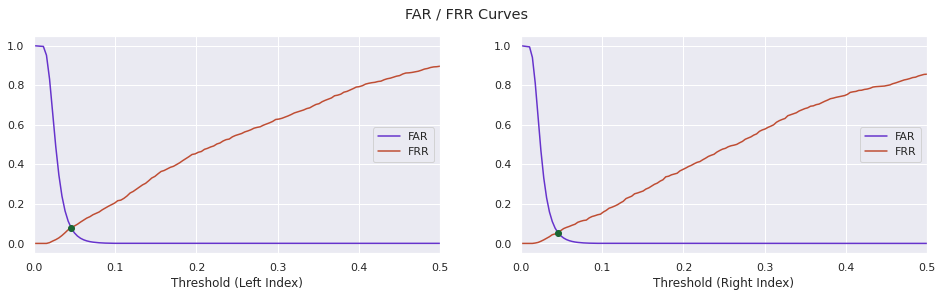

In [115]:
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""

# Calculate index in array where difference between FNR and FPR is smallest
#  - you can use an interpolated or discrete approximation, both are fine
#  - avoid using a library for this assignment 
li_differences = [abs((1-x)-y) for (x,y) in zip(li_tpr, li_fpr)]
li_min_index = li_differences.index(min(li_differences))
ri_differences = [abs((1-x)-y) for (x,y) in zip(ri_tpr, ri_fpr)]
ri_min_index = ri_differences.index(min(ri_differences))
#li_min_index = np.nanargmin(np.absolute(((1-li_tpr) - li_fpr)))
#ri_min_index = np.nanargmin(np.absolute(((1-ri_tpr) - ri_fpr)))
print("EER (Left Index) : (", li_roc_thresholds[li_min_index], li_fpr[li_min_index], ")")
print("FPR at this threshold = %f." % (len(li_imposter[li_imposter >= li_roc_thresholds[li_min_index]]) / float(len(li_imposter))))
print("FRR at this threshold = %f." % (len(li_genuine[li_genuine < li_roc_thresholds[li_min_index]]) / float(len(li_genuine))))
print("---")
print("EER (Right Index) : (", ri_roc_thresholds[ri_min_index], ri_fpr[ri_min_index], ")")
print("FPR at this threshold = %f." % (len(ri_imposter[ri_imposter >= ri_roc_thresholds[ri_min_index]]) / float(len(ri_imposter))))
print("FRR at this threshold = %f." % (len(ri_genuine[ri_genuine < ri_roc_thresholds[ri_min_index]]) / float(len(ri_genuine))))

# Plot EER
figure, axes = plt.subplots(ncols=2, figsize=(16,4))
figure.suptitle('FAR / FRR Curves')
axes[0].scatter(li_roc_thresholds[li_min_index], li_fpr[li_min_index], color=(0.1,0.4,0.2), zorder=3)
axes[0].plot(li_roc_thresholds, li_fpr, color=(0.4,0.2,0.8), label='FAR')
axes[0].plot(li_roc_thresholds, 1-li_tpr, color=(0.75,0.3,0.2), label='FRR')
axes[0].set(xlabel='Threshold (Left Index)', xlim=[0.0,0.5])
axes[0].legend();
axes[1].scatter(ri_roc_thresholds[ri_min_index], ri_fpr[ri_min_index], color=(0.1,0.4,0.2), zorder=3)
axes[1].plot(ri_roc_thresholds, ri_fpr, color=(0.4,0.2,0.8), label='FAR')
axes[1].plot(ri_roc_thresholds, 1-ri_tpr, color=(0.75,0.3,0.2), label='FRR')
axes[1].set(xlabel='Threshold (Right Index)', xlim=[0.0,0.5])
axes[1].legend();

*The EER represents the point where you can't lower the rate of one type of error without increase the rate of the other. While the FRR decreased the FAR increased in comparison to the operating point discussed in the context of the F1 measure. Depending on the requirements this may or may not be a good thing. If security is key, it isn't.*

In [117]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
li_sums = [abs((1-x)+y) for (x,y) in zip(li_tpr, li_fpr)]
ri_sums = [abs((1-x)+y) for (x,y) in zip(ri_tpr, ri_fpr)]
li_sum_min_t = li_roc_thresholds[li_sums.index(min(li_sums))]
ri_sum_min_t = ri_roc_thresholds[ri_sums.index(min(ri_sums))]
print('Minimum threshold (Left Index) : % f' % li_sum_min_t)
print("FPR at this threshold = %f." % (len(li_imposter[li_imposter >= li_sum_min_t]) / float(len(li_imposter))))
print("FRR at this threshold = %f." % (len(li_genuine[li_genuine < li_sum_min_t]) / float(len(li_genuine))))
print("---")
print('Minimum threshold (Right Index) : % f' % ri_sum_min_t)
print("FPR at this threshold = %f." % (len(ri_imposter[ri_imposter >= ri_sum_min_t]) / float(len(ri_imposter))))
print("FRR at this threshold = %f." % (len(ri_genuine[ri_genuine < ri_sum_min_t]) / float(len(ri_genuine))))

Minimum threshold (Left Index) :  0.057252
FPR at this threshold = 0.026062.
FRR at this threshold = 0.108000.
---
Minimum threshold (Right Index) :  0.059441
FPR at this threshold = 0.013835.
FRR at this threshold = 0.086000.


*Because of the steepness of the FAR rate around the EER the FAR can be decreased without increasing the FRR as much.*

*The result is not similar to the total classification error due to class imbalance : the sum here takes into account genuine - and imposter scores separately and weighs the cost of the related errors equally.*

*This assumption that the costs of false positives or false rejections are equal may not be desired, and a more generic approach is used next.*

In [118]:
"""Generic approach where 'costs' are assigned to each type of error (see alpha and beta parameters)."""
def min_sum(tpr=li_tpr, fpr=li_fpr, thresholds=li_roc_thresholds, alpha=0.01, beta=0.99):
    sums = [abs(alpha*(1-x)+beta*y) for (x,y) in zip(tpr, fpr)]
    return thresholds[sums.index(min(sums))]
li_sum_min_t = min_sum()
ri_sum_min_t = min_sum(ri_tpr, ri_fpr, ri_roc_thresholds)
print('Minimum threshold (Left Index) : % f' % li_sum_min_t)
print("FPR at this threshold = %f." % (len(li_imposter[li_imposter >= li_sum_min_t]) / float(len(li_imposter))))
print("FRR at this threshold = %f." % (len(li_genuine[li_genuine < li_sum_min_t]) / float(len(li_genuine))))
print("---")
print('Minimum threshold (Right Index) : % f' % ri_sum_min_t)
print("FPR at this threshold = %f." % (len(ri_imposter[ri_imposter >= ri_sum_min_t]) / float(len(ri_imposter))))
print("FRR at this threshold = %f." % (len(ri_genuine[ri_genuine < ri_sum_min_t]) / float(len(ri_genuine))))

Minimum threshold (Left Index) :  0.106870
FPR at this threshold = 0.000277.
FRR at this threshold = 0.219000.
---
Minimum threshold (Right Index) :  0.097902
FPR at this threshold = 0.000354.
FRR at this threshold = 0.148000.


*Here, the FPR is prioritised to increase security at the cost of convenience.*

#### 5. Evaluation using Precision and Recall

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)
[3]: <https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision> (Average precision)

In a general binary classification setting, one also often presents Precision-Recall curves. PR-curves are sometimes summarized using the [average precision scores][3]. How and when to use ROC or PRC is discussed [here][2]. A more general discussion of these measures is provided [here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c).  

Scikit-Learn provides routines for calculating these curves and numbers as demonstrated in the code below from this [link][2], it also provides an implementation of the [average precision scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score).


#### Task 1.5 Experiment with Precision-Recall curves and related summary measures

* Calculate and plot the Precision-Recall curve for this system. 
 * What does it reveal about the performance of the system?
* Calculate the Area Under the PR-curve. 
 * Discuss.
* Calculate the average precision scores. 
 * Discuss its value.

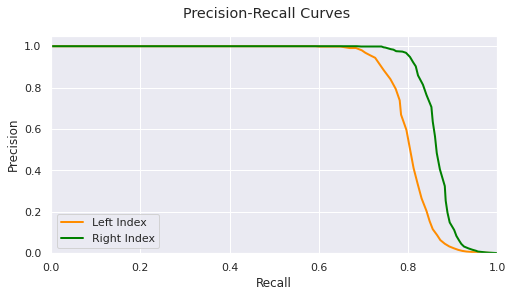

In [119]:
"""Calculate and plot the Precision-Recall curve for this system"""

# Calculate PR curve
from sklearn.metrics import precision_recall_curve
li_precision, li_recall, _ = precision_recall_curve(li_genuine_id, li_scores)
ri_precision, ri_recall, _ = precision_recall_curve(ri_genuine_id, ri_scores)

# Plot PR curve
figure, axes = plt.subplots(ncols=1, figsize=(8,4))
figure.suptitle('Precision-Recall Curves')
axes.plot(li_recall, li_precision, color='darkorange', lw=2, label='Left Index')
axes.plot(ri_recall, ri_precision, color='green', lw=2, label='Right Index')
axes.set(xlabel='Recall', ylabel='Precision', xlim=[0.0,1.0], ylim=[0.0,1.05])
axes.legend()
plt.show()

*The PR-curve is more realistic about the performance of each system as it doesn't suffer from the class imbalance as much.*

In [120]:
"""Calculate the Area Under the PR-curve."""
from sklearn.metrics import auc
print('AUC (Left Index) : % f' % auc(li_recall, li_precision))
print('AUC (Right Index) : % f' % auc(ri_recall, ri_precision))

AUC (Left Index) :  0.803478
AUC (Right Index) :  0.862757


*The AUC metric is valuable to get an idea of the model's performance and to compare the two systems, but just like the AUC for the ROC curves it doesn't give the complete picture.*

In [121]:
"""Calculate the average precision scores"""
from sklearn.metrics import average_precision_score
print('Average precision score (Left Index) : % f' % average_precision_score(li_genuine_id, li_scores))
print('Average precision score (Right Index) : % f' % average_precision_score(ri_genuine_id, ri_scores))

Average precision score (Left Index) :  0.798897
Average precision score (Right Index) :  0.859512


*The average precision is the same as the AUC but sklearn uses a different (less optimistic) method to calculate it.*

## Validation of identification  

### Evaluation using CMC curves
In an identification scenario one has a 1-to-many or multi-class classification problem. The performance of such a system is typically measured by the Cumulative Match Characteristic (CMC) curve. This curve plots the experimental probability that a correct identification is returned within the top-x (x=1, ..., N) ranked matching scores. 

<p align="center">
  <img src="https://imgur.com/e6QO8I5.jpg" width=300>
</p>

[Bolle et al.](https://ieeexplore.ieee.org/document/1544394) show that:
> the CMC is also related to the FAR and FRR of a 1:1 matcher, i.e., the matcher that is used to rank the candidates by sorting the scores. This has as a consequence that when a 1:1 matcher is used for identification, that is, for sorting match scores from high to low, the CMC does not offer any additional information beyond the FAR and FRR curves. The CMC is just another way of displaying the data and can be computed from the FAR and FRR.

This paper is not mandatory but those interested can have a look at it.

CMC curves can easily be generated once you have the ranked matching scores for every test sample. In our example we can easily calculate it from the similarity matrix (note that in this very particular case we have only one genuine pair per test sample). 



#### Task 1.6 Experiment with CMC

* Calculate the Cumulative Matching Characteristic curve (implement this yourself)
* Compute the Rank-1 Recognition Rate.

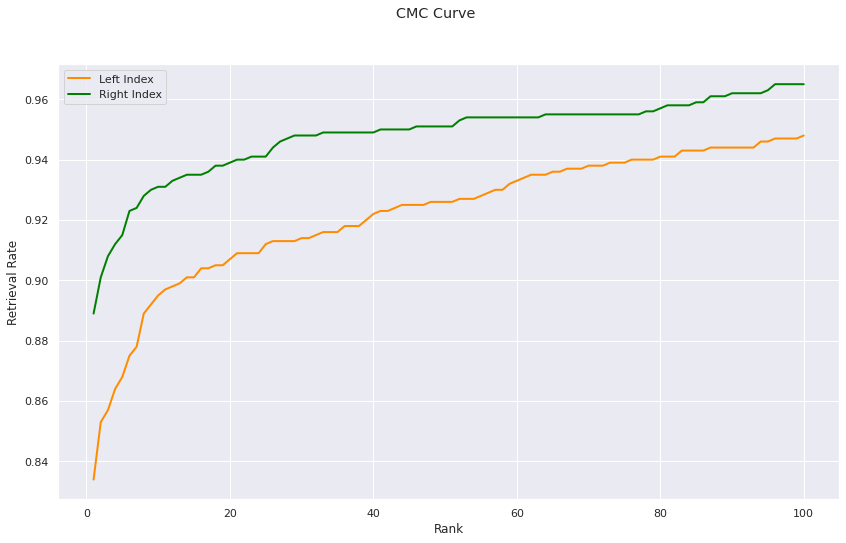

In [122]:
"""Calculate the Cumulative Matching Characteristic curve."""
def CMC(similarity_matrix, n_ranks):
    # 1.1) compute the rank of the column elements (enrollees) for every row (user)
    # 1.2) calculate how frequent each rank occurs on the diagonal (diagonal contains the correct identifications)
    cmc = [0] * n_ranks
    for (i,row) in enumerate(similarity_matrix):
        #rank = sorted(row, reverse=True).index(row[i])
        rank = len(row) - 1 - np.argsort(np.argsort(row))[i] # not the same as the line above (duplicates ...)
        if rank < n_ranks:
            cmc[rank] += 1
    # 1.3) compute the cumulative frequency for each rank and normalise the result 
    # 1.4) return the CMC
    prev = 0
    for i in range(n_ranks):
        prev = cmc[i] + prev
        cmc[i] = prev / 1000
    return cmc

# 1) compute the CMC for the first ±100 ranks
n_ranks = 100
li_cmc = CMC(li_similarity_matrix.values.tolist(), n_ranks)
ri_cmc = CMC(ri_similarity_matrix.values.tolist(), n_ranks)

# 2) plot the probability of recognition in function of the rank
figure, axes = plt.subplots(ncols=1, figsize=(14,8))
figure.suptitle('CMC Curve')
axes.plot(list(range(1,n_ranks+1)), li_cmc, color='darkorange', lw=2, label='Left Index')
axes.plot(list(range(1,n_ranks+1)), ri_cmc, color='green', lw=2, label='Right Index')
axes.set(xlabel='Rank', ylabel='Retrieval Rate')
axes.legend()
plt.show()

In [123]:
"""compute the Rank-1 Recognition Rate."""
print('Rank-1 Recognition Rate (Left Index) : % f' % li_cmc[0])
print('Rank-1 Recognition Rate (Right Index) : % f' % ri_cmc[0])

Rank-1 Recognition Rate (Left Index) :  0.834000
Rank-1 Recognition Rate (Right Index) :  0.889000


#### Task 1.7 Evaluate different biometric systems
    
With all above plots and metrics, you can start comparing different biometric systems (same biometric with different implementation, or different biometrics) in an authentication/verification and identification scenario. 
    
* Do this for comparing the left index from the right index finger.
* Do you see any differences in any of the curves or measures?

*In all the experiments the results were clear : the system making use of the right index outperforms that making use of the left index. The ROC & PR curves for the right index lie above that of the left index, such that summarising metrics like AUC aren't even necessary. There's also the possibility of using an ensemble ; below, a combination of both systems are used and some of the metrics are re-calculated.*

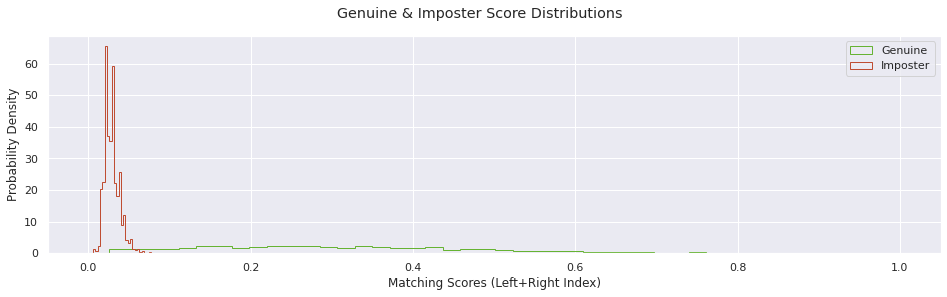

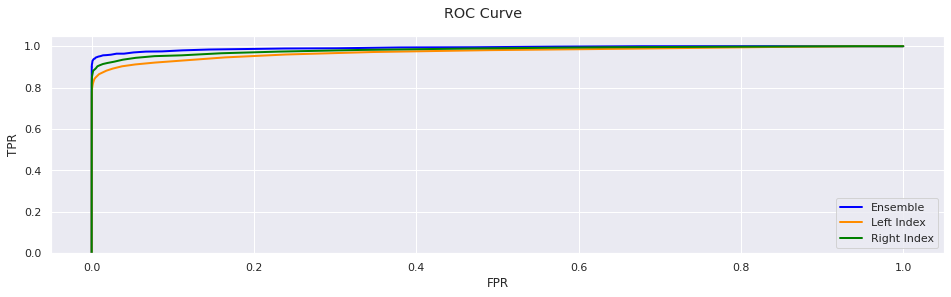

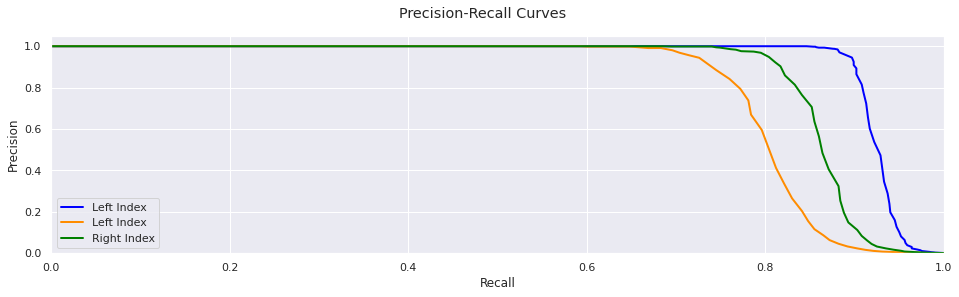

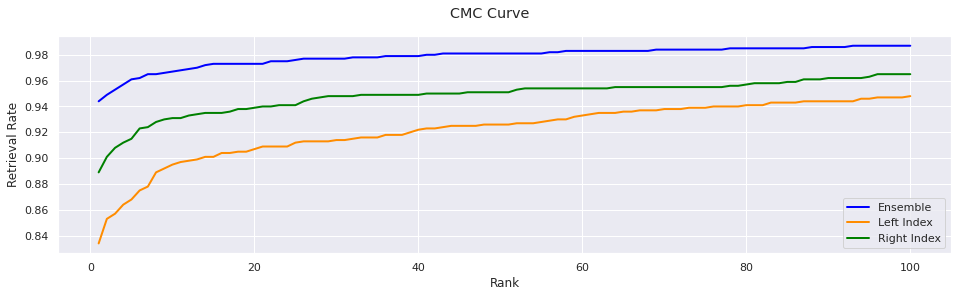

AUC (Ensemble) :  0.924912
AUC (Left Index) :  0.803478
AUC (Right Index) :  0.862757


In [124]:
similarity_matrix = 0.5 * li_similarity_matrix + 0.5 * ri_similarity_matrix
genuine_id, scores = BSSR1.sim2scores(similarity_matrix)

# Probability density functions
kwargs = dict(histtype='step', density=True, bins=45)
figure, axes = plt.subplots(ncols=1, figsize=(16,4))
figure.suptitle('Genuine & Imposter Score Distributions')
axes.hist(scores[genuine_id > 0], color=(0.4,0.7,0.2), label='Genuine', **kwargs)
axes.hist(scores[genuine_id < 1], color=(0.75,0.3,0.2), label='Imposter', **kwargs)
axes.set(xlabel='Matching Scores (Left+Right Index)', ylabel='Probability Density')
axes.legend();
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(genuine_id, scores)
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
figure.suptitle('ROC Curve')
axes.plot(fpr, tpr, color='blue', lw=2, label='Ensemble')
axes.plot(li_fpr, li_tpr, color='darkorange', lw=2, label='Left Index')
axes.plot(ri_fpr, ri_tpr, color='green', lw=2, label='Right Index')
# equal = np.linspace(0.0,1.0,50).tolist() # FPR == FRR
# axes.plot(equal, equal[::-1], '--', color=[0.4,0.4,1.0], label='FPR == FRR')
axes.set(xlabel='FPR', ylabel='TPR', ylim=[0.0,1.05])
axes.legend()
plt.show()

# PR curve
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(genuine_id, scores)
figure, axes = plt.subplots(ncols=1, figsize=(16,4))
figure.suptitle('Precision-Recall Curves')
axes.plot(recall, precision, color='blue', lw=2, label='Left Index')
axes.plot(li_recall, li_precision, color='darkorange', lw=2, label='Left Index')
axes.plot(ri_recall, ri_precision, color='green', lw=2, label='Right Index')
axes.set(xlabel='Recall', ylabel='Precision', xlim=[0.0,1.0], ylim=[0.0,1.05])
axes.legend()
plt.show()

# CMC
n_ranks = 100
cmc = CMC(similarity_matrix.values.tolist(), n_ranks)
figure, axes = plt.subplots(ncols=1, figsize=(16,4))
figure.suptitle('CMC Curve')
axes.plot(list(range(1,n_ranks+1)), cmc, color='blue', lw=2, label='Ensemble')
axes.plot(list(range(1,n_ranks+1)), li_cmc, color='darkorange', lw=2, label='Left Index')
axes.plot(list(range(1,n_ranks+1)), ri_cmc, color='green', lw=2, label='Right Index')
axes.set(xlabel='Rank', ylabel='Retrieval Rate')
axes.legend()
plt.show()

# AUC (for PR)
print('AUC (Ensemble) : % f' % auc(recall, precision))
print('AUC (Left Index) : % f' % auc(li_recall, li_precision))
print('AUC (Right Index) : % f' % auc(ri_recall, ri_precision))